In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from IPython.display import display, display_html, HTML
from functools import partial
import pprint
import requests
import pickle
import json
import os

# Scikit-learn imports
from sklearn.metrics import (
    confusion_matrix, auc, roc_curve, roc_auc_score, 
    classification_report, ConfusionMatrixDisplay, 
    RocCurveDisplay, accuracy_score, precision_score, 
    recall_score, f1_score, make_scorer
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedShuffleSplit, 
    GridSearchCV, cross_val_predict, StratifiedKFold
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_sample_weight
from sklearn.base import BaseEstimator, TransformerMixin


# Set max columns and rows to display
pd.set_option('display.max_columns', 500)

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
csv_file_path = os.path.join('..', 'data', 'two-years-recid.csv')

df = pd.read_csv(csv_file_path)

print(df.shape)
df.head()

(6114, 35)


,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [3]:
selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in", "is_recid"]

df = df.copy()[selected_columns]

df.head()

,id,name,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_case_number,c_charge_degree,c_charge_desc,c_offense_date,c_arrest_date,c_jail_in,is_recid
0,1,steven lux,Male,1953-06-15,Caucasian,0,0,0,0,13000208CF10A,F,False Imprisonment,2013-01-05,NaN,2013-01-05 04:35:31,0
1,2,andre small,Male,1987-10-01,African-American,0,0,0,1,13006354MM10A,M,Battery,2013-04-02,NaN,2013-04-02 12:18:46,0
2,3,willie gray,Male,1959-01-12,African-American,0,0,0,8,14040148MU10A,M,DUI Level 0.15 Or Minor In Veh,2014-10-30,NaN,2014-10-31 12:02:01,1
3,4,nickson marcellus,Male,1996-07-11,African-American,0,1,0,1,13017969CF10A,F,arrest case no charge,NaN,2014-01-23,2014-01-23 03:19:30,1
4,5,patria barnes,Female,1978-06-06,Other,0,0,0,0,13022717MM10A,M,Battery,2013-12-07,NaN,2013-12-08 01:55:28,0


In [5]:
# check percentage of missing values per feature
missing_values = df.isnull().mean() * 100

missing_values

id                  0.000000
name                0.000000
sex                 0.000000
dob                 0.000000
race                0.000000
juv_fel_count       0.000000
juv_misd_count      0.000000
juv_other_count     0.000000
priors_count        0.000000
c_case_number       0.294406
c_charge_degree     0.000000
c_charge_desc       0.392542
c_offense_date     15.685312
c_arrest_date      84.609094
c_jail_in           4.252535
is_recid            0.000000
dtype: float64

In [4]:
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in"
        ]
    
    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self
    
    def transform(self, X):
        # Make a copy of the dataframe to avoid modifying the original input
        df = X.copy()
        
        # Convert dates to datetime
        df['dob'] = pd.to_datetime(df['dob'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

        # Age Calculation as an integer
        df['age_at_arrest'] = (df['c_jail_in'] - df['dob']).dt.days // 365

        # Age group
        age_bins = [0, 24, 34, 44, 54, 100]
        age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
        df['age_group'] = pd.cut(df['age_at_arrest'], bins=age_bins,
                                 labels=age_labels, right=False)

        # Replace c_charge_degree
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('F', 'Felony')
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('M', 'Misdemeanor')
        df['c_charge_degree'] = df['c_charge_degree'].fillna('Missing')
        
        # Calculate sample weights chosen
        df['weights_race'] = compute_sample_weight(class_weight='balanced', y=df['race'])
        
        # Drop unnecessary columns
        df = df.drop(['dob', 'c_case_number', 'c_charge_desc', 'c_offense_date', 'c_arrest_date', 'name', 'c_jail_in', 'age_at_arrest'], axis=1)

        return df


# Create an instance of the FeatureCreation class
df_processed = FeatureCreation().fit_transform(df).set_index('id')

# Split the data into features (X) and target (y)
X = df_processed.drop(columns=['is_recid','weights_race'])
y = df['is_recid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Define the logistic regression classifier
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Define the pipeline
pipe_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_baseline)
])

# Fit the pipeline with weights
sample_weights = df_processed.loc[X_train.index, 'weights_race']
# Fit the pipeline with weights
pipe_baseline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

y_pred_baseline = pipe_baseline.predict(X_test)

In [5]:
# shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4891, 8), (1223, 8), (4891,), (1223,))

In [6]:
# show weight for each class sorted by class label
df_processed[['race','weights_race']].groupby('race').mean().sort_values('weights_race',ascending=False).style.format("{:.2f}").background_gradient(cmap='viridis')

,weights_race
race,
Native American,78.38
Asian,39.19
Other,3.14
Hispanic,1.87
Caucasian,0.49
African-American,0.33


In [7]:
# Transform the data using the pipeline
X_train_transformed = pipe_baseline.named_steps['preprocessor'].transform(X_train)

# Get the transformed numerical columns
num_cols_transformed = pipe_baseline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=num_cols)

# Get the transformed categorical columns
cat_cols_transformed = pipe_baseline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

# Combine numerical and categorical transformed columns
columns_transformed = list(num_cols_transformed) + list(cat_cols_transformed)

# Create a DataFrame with transformed data
X_train_transformed = pd.DataFrame(X_train_transformed, columns=columns_transformed)

# Display the transformed DataFrame
X_train_transformed.head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_Felony,c_charge_degree_Misdemeanor,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55+,age_group_<25
0,-0.166508,-0.190829,1.991071,-0.497269,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.166508,-0.190829,-0.225712,0.123915,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.166508,-0.190829,-0.225712,-0.704330,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.166508,-0.190829,-0.225712,-0.497269,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.166508,-0.190829,-0.225712,-0.497269,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


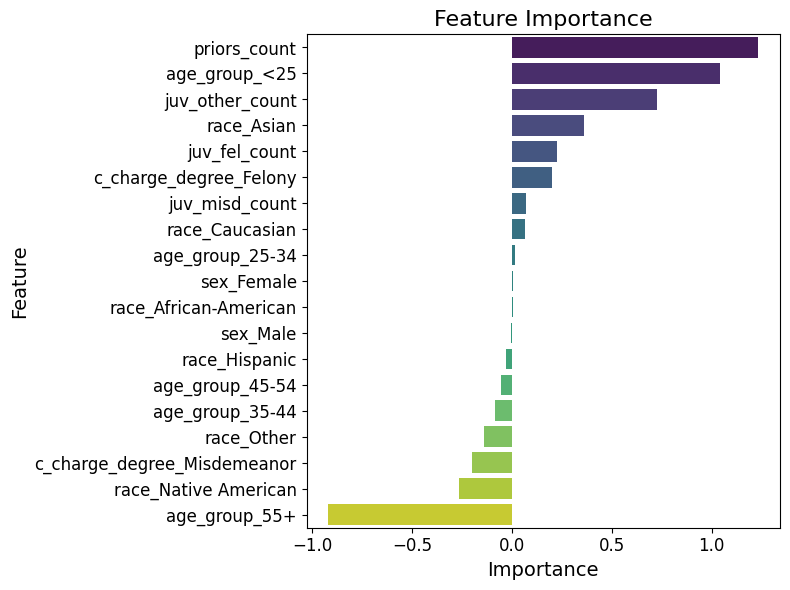

In [8]:
# Feature importance from the classifier
feature_importance = pipe_baseline.named_steps['classifier'].coef_[0]

# Get the feature names from the preprocessor
num_cols_feature = pipe_baseline.named_steps['preprocessor'].transformers_[0][2]
cat_cols_feature = pipe_baseline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=cat_cols).tolist()

# Combine feature names and importances
feature_names = num_cols_feature + cat_cols_feature
feature_importance_combined = list(feature_importance[:len(num_cols_feature)]) + list(feature_importance[len(num_cols_feature):])  # Splitting feature_importance for numerical and categorical features

# Create a DataFrame to display feature names and importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_combined})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance with improved visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
print(X.columns)
print(X.dtypes)

Index(['sex', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'age_group'],
      dtype='object')
sex                  object
race                 object
juv_fel_count         int64
juv_misd_count        int64
juv_other_count       int64
priors_count          int64
c_charge_degree      object
age_group          category
dtype: object


In [10]:
pipe_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sex', 'race',
                                                   'c_charge_degree',
                                                   'age_group'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

Training and evaluating Logistic Regression...
Training and evaluating Random Forest...
Training and evaluating Support Vector Machine...
Training and evaluating XGBoost...


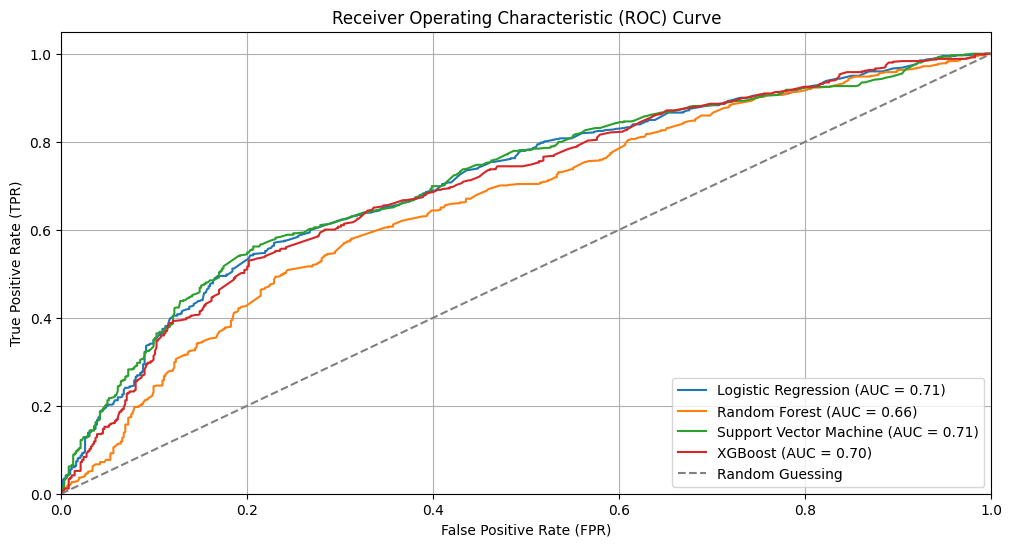

Summary of Results:
               Classifier  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.667212   0.686160  0.588629  0.633663
1           Random Forest  0.627964   0.645030  0.531773  0.582951
2  Support Vector Machine  0.677841   0.717949  0.561873  0.630394
3                 XGBoost  0.659035   0.669159  0.598662  0.631951


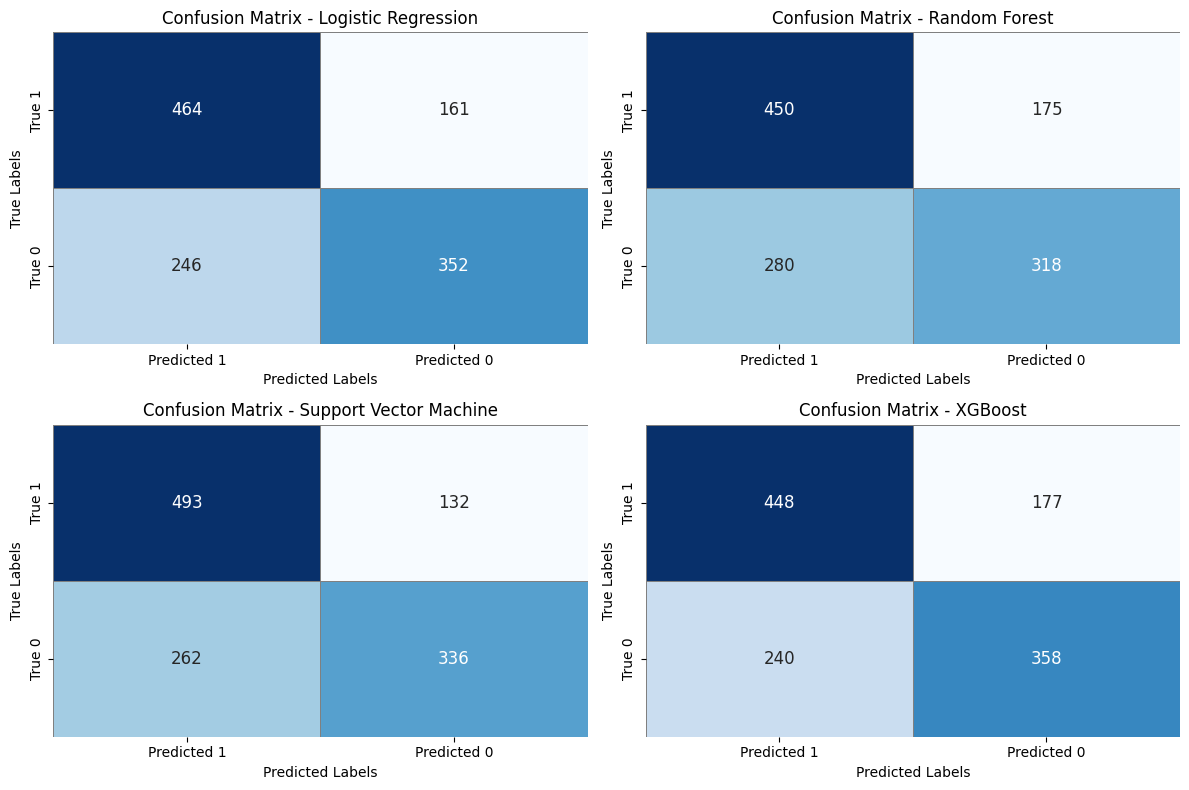

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier()
}

# Initialize lists to store results
results = []
confusion_matrices = []
roc_curves = []

# Initialize figure for ROC curve
plt.figure(figsize=(12, 6))

# Loop through each classifier and test
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name}...")
    
    pipe_baseline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    pipe_baseline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    
    # Predict probabilities on test data
    y_pred_proba = pipe_baseline.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store ROC curve data
    roc_curves.append({
        'Classifier': clf_name,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    })
    
    # Predict on test data
    y_pred = pipe_baseline.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store metrics in results list
    results.append({
        'Classifier': clf_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Store confusion matrix in confusion_matrices list
    confusion_matrices.append({
        'Classifier': clf_name,
        'Confusion Matrix': conf_matrix
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing (no skill)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guessing')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display results DataFrame
print("Summary of Results:")
print(results_df)

# Optionally, visualize confusion matrices
plt.figure(figsize=(12, 8))
for i, (clf_name, conf_matrix) in enumerate(zip(classifiers.keys(), confusion_matrices), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(conf_matrix['Confusion Matrix'], annot=True, cmap='Blues', fmt='d', cbar=False,
                annot_kws={'size': 12}, linewidths=0.5, linecolor='grey',
                xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['True 1', 'True 0'])
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [12]:
# Function to highlight maximum value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

# Apply styling to the DataFrame
styled_df = results_df.style \
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}'
    }) \
    .apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1 Score']) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])

# Display styled DataFrame
styled_df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.6672,0.6862,0.5886,0.6337
1,Random Forest,0.6280,0.6450,0.5318,0.5830
2,Support Vector Machine,0.6778,0.7179,0.5619,0.6304
3,XGBoost,0.6590,0.6692,0.5987,0.6320


Training and evaluating Logistic Regression...
Training and evaluating Support Vector Machine...


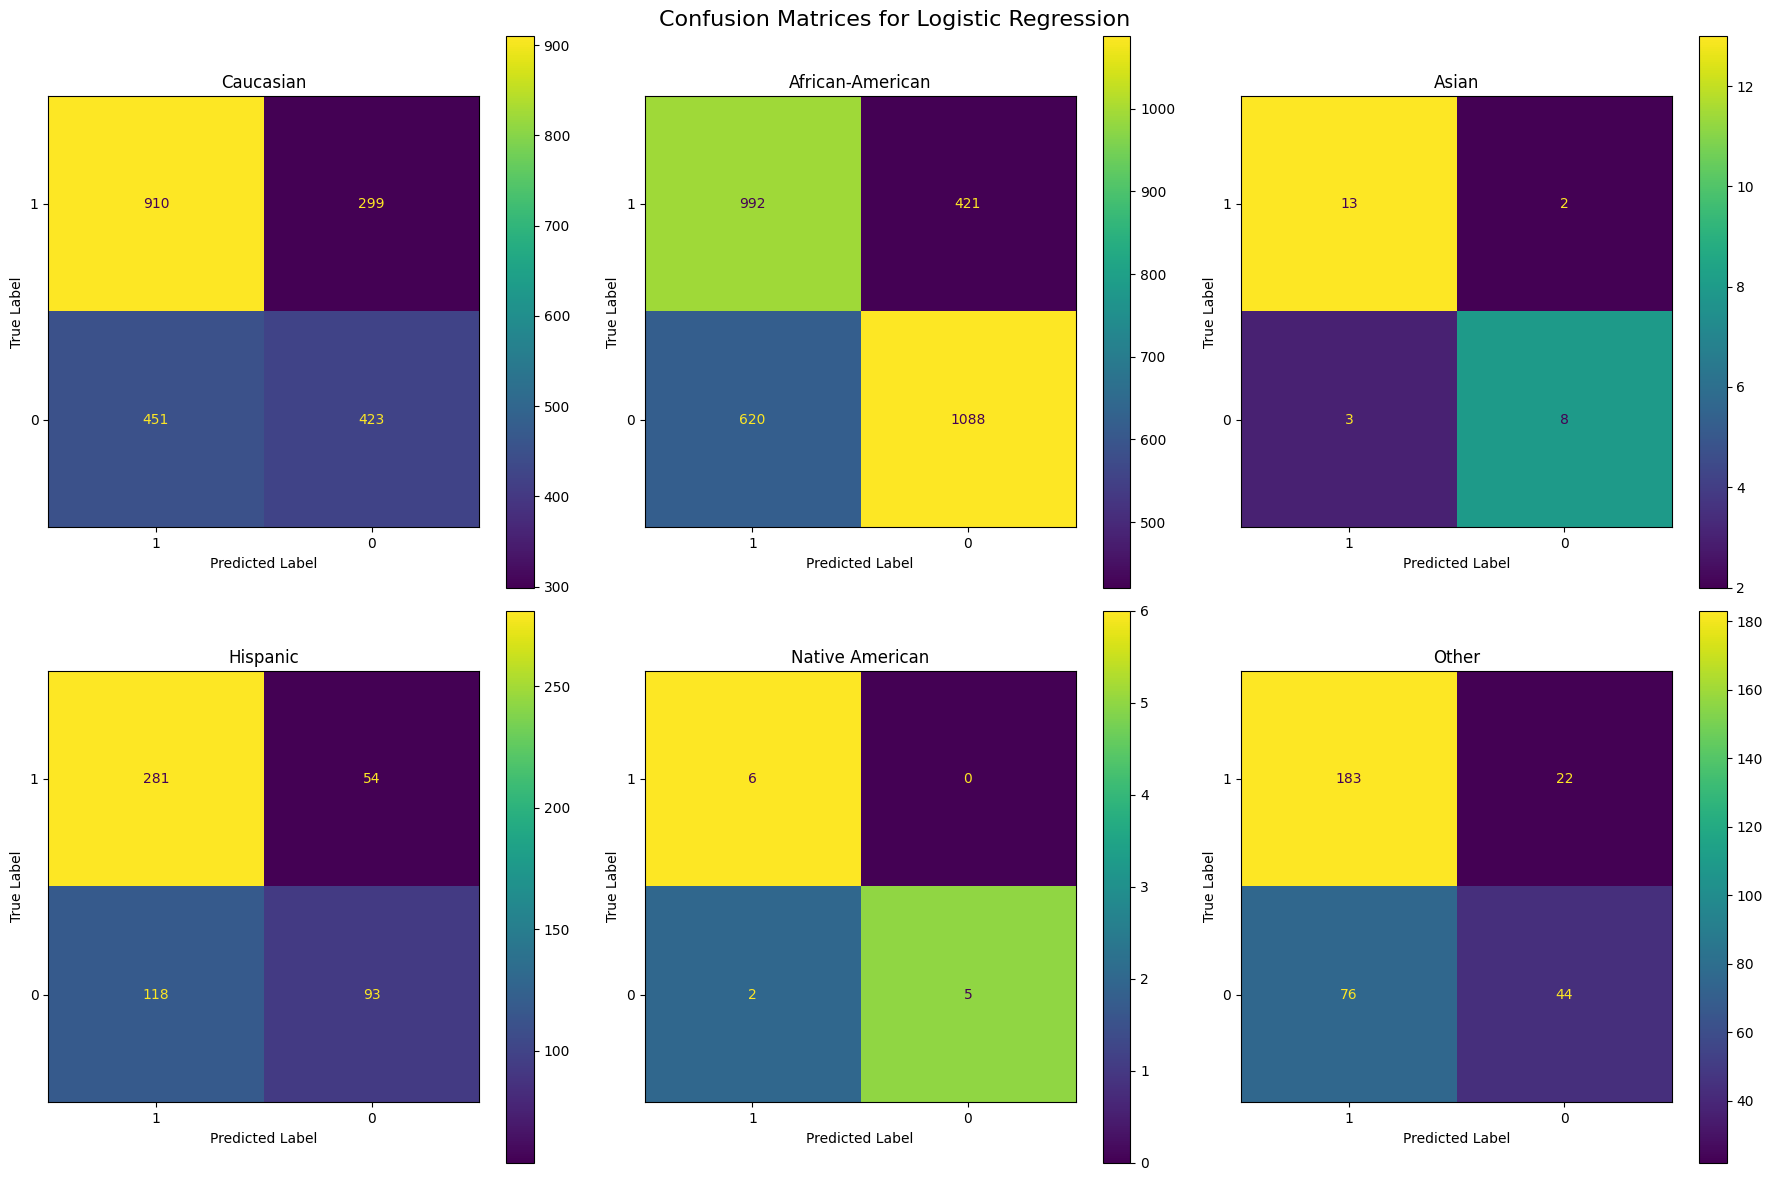

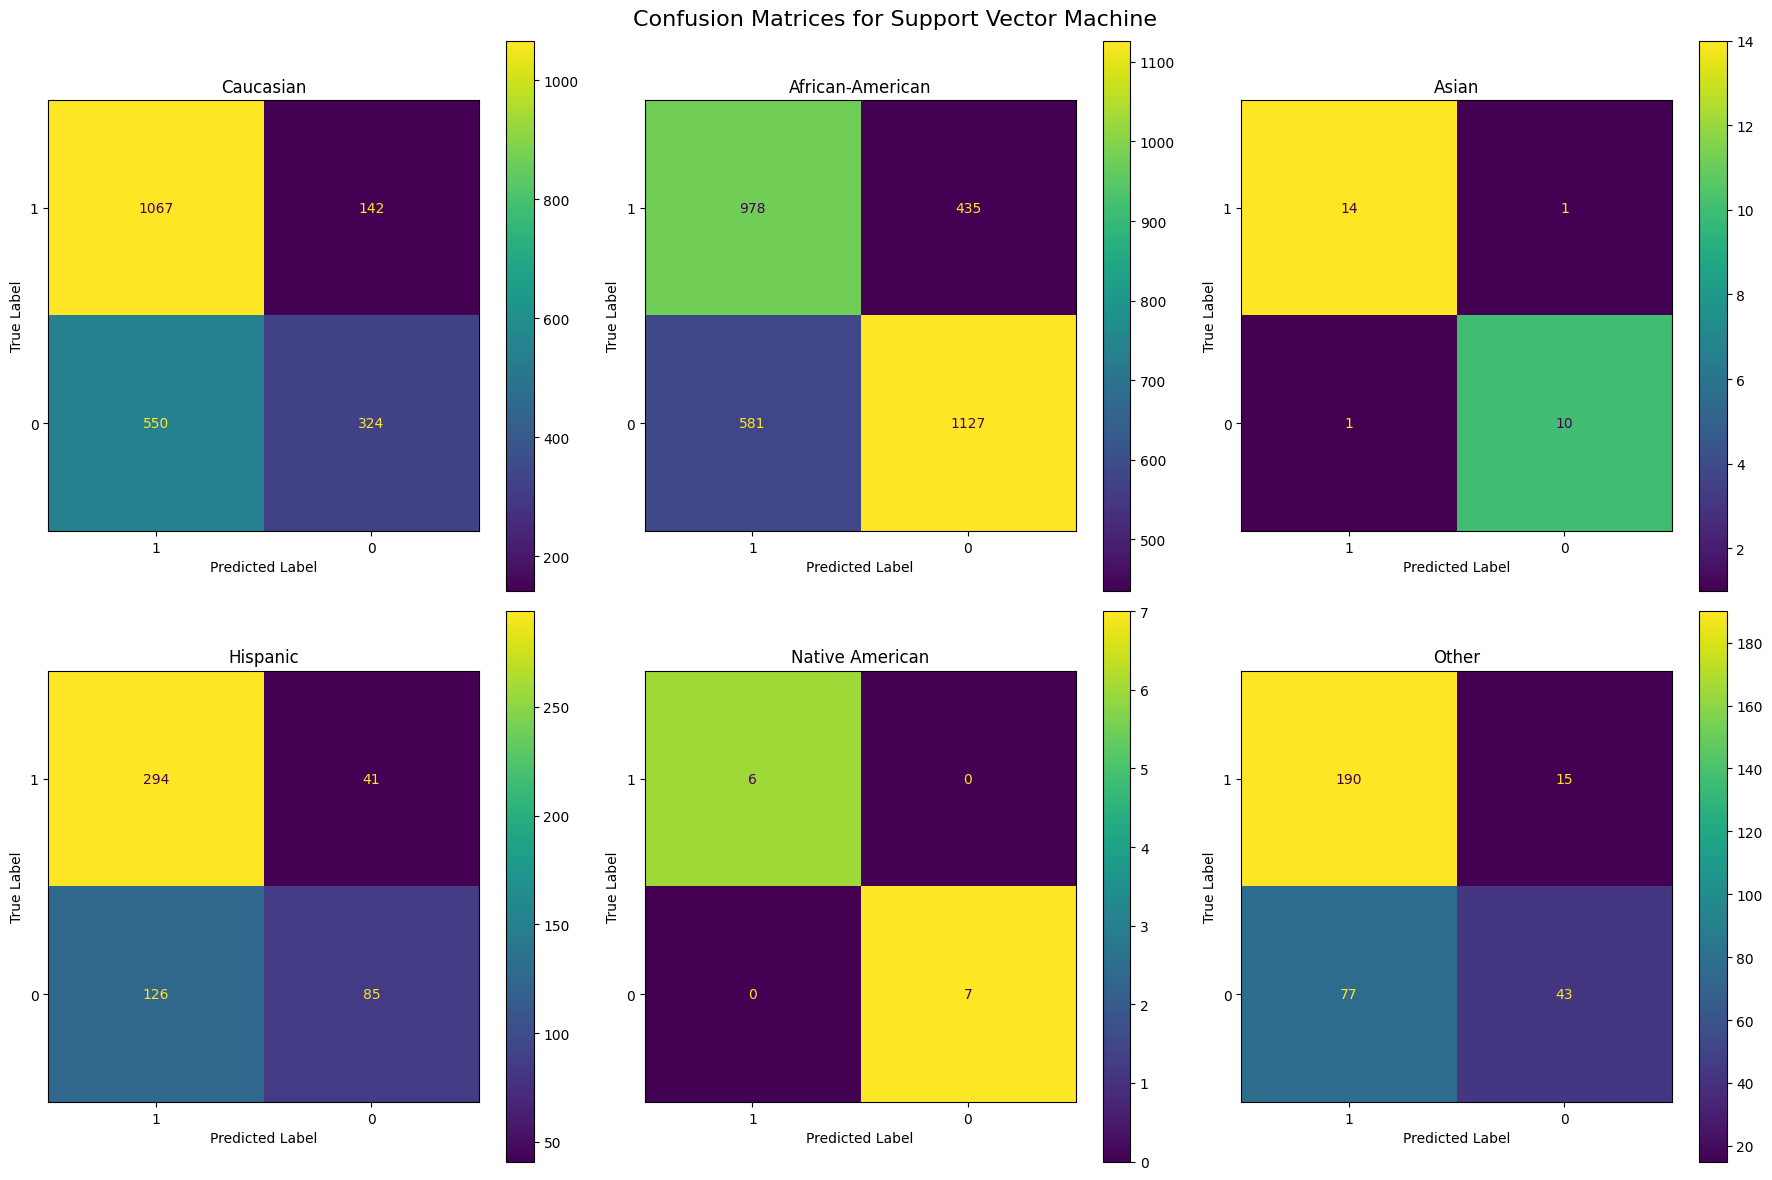


Metrics for Logistic Regression:

Race: Caucasian
confusion_matrix:
[[910 299]
 [451 423]]
accuracy: 0.6399423907825252
precision: 0.5858725761772853
recall: 0.4839816933638444
f1_score: 0.5300751879699248

Race: African-American
confusion_matrix:
[[ 992  421]
 [ 620 1088]]
accuracy: 0.6664530599166933
precision: 0.7210072895957588
recall: 0.6370023419203747
f1_score: 0.6764065899906745

Race: Asian
confusion_matrix:
[[13  2]
 [ 3  8]]
accuracy: 0.8076923076923077
precision: 0.8
recall: 0.7272727272727273
f1_score: 0.761904761904762

Race: Hispanic
confusion_matrix:
[[281  54]
 [118  93]]
accuracy: 0.684981684981685
precision: 0.6326530612244898
recall: 0.44075829383886256
f1_score: 0.5195530726256984

Race: Native American
confusion_matrix:
[[6 0]
 [2 5]]
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.7142857142857143
f1_score: 0.8333333333333333

Race: Other
confusion_matrix:
[[183  22]
 [ 76  44]]
accuracy: 0.6984615384615385
precision: 0.6666666666666666
recall: 0.366666666

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    #'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    #'XGBoost': XGBClassifier()
}

# Dictionary to hold metrics for each classifier and race
all_race_metrics = {clf_name: {} for clf_name in classifiers.keys()}

# Define races
races = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return cm, accuracy, precision, recall, f1

# Loop through each classifier
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name}...")
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Fit the pipeline
    pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    
    # Get predictions
    df['pred_baseline'] = pipe.predict(X)
    df['pred_baseline_prob'] = pipe.predict_proba(X)[:, 1]
    
    # Calculate metrics for each race
    for race in races:
        race_data = df[df['race'] == race]
        y_true = race_data['is_recid']
        y_pred = race_data['pred_baseline']
        
        cm, accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
        
        if race not in all_race_metrics[clf_name]:
            all_race_metrics[clf_name][race] = {
                'confusion_matrix': cm,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
        else:
            all_race_metrics[clf_name][race] = {
                'confusion_matrix': cm,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

# Plot confusion matrices for each classifier and race
for clf_name in classifiers.keys():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Confusion Matrices for {clf_name}', fontsize=16)
    
    for ax, race in zip(axes.flatten(), races):
        ConfusionMatrixDisplay(all_race_metrics[clf_name][race]['confusion_matrix'], display_labels=[1,0]).plot(ax=ax, cmap='viridis')
        ax.set_title(f'{race}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

# Optionally, you can print or further analyze the race metrics for each classifier
for clf_name in classifiers.keys():
    print(f"\nMetrics for {clf_name}:")
    for race in races:
        print(f"\nRace: {race}")
        for metric, value in all_race_metrics[clf_name][race].items():
            if metric == 'confusion_matrix':
                print(f"{metric}:\n{value}")
            else:
                print(f"{metric}: {value}")


Training and evaluating Logistic Regression...
Training and evaluating Support Vector Machine...


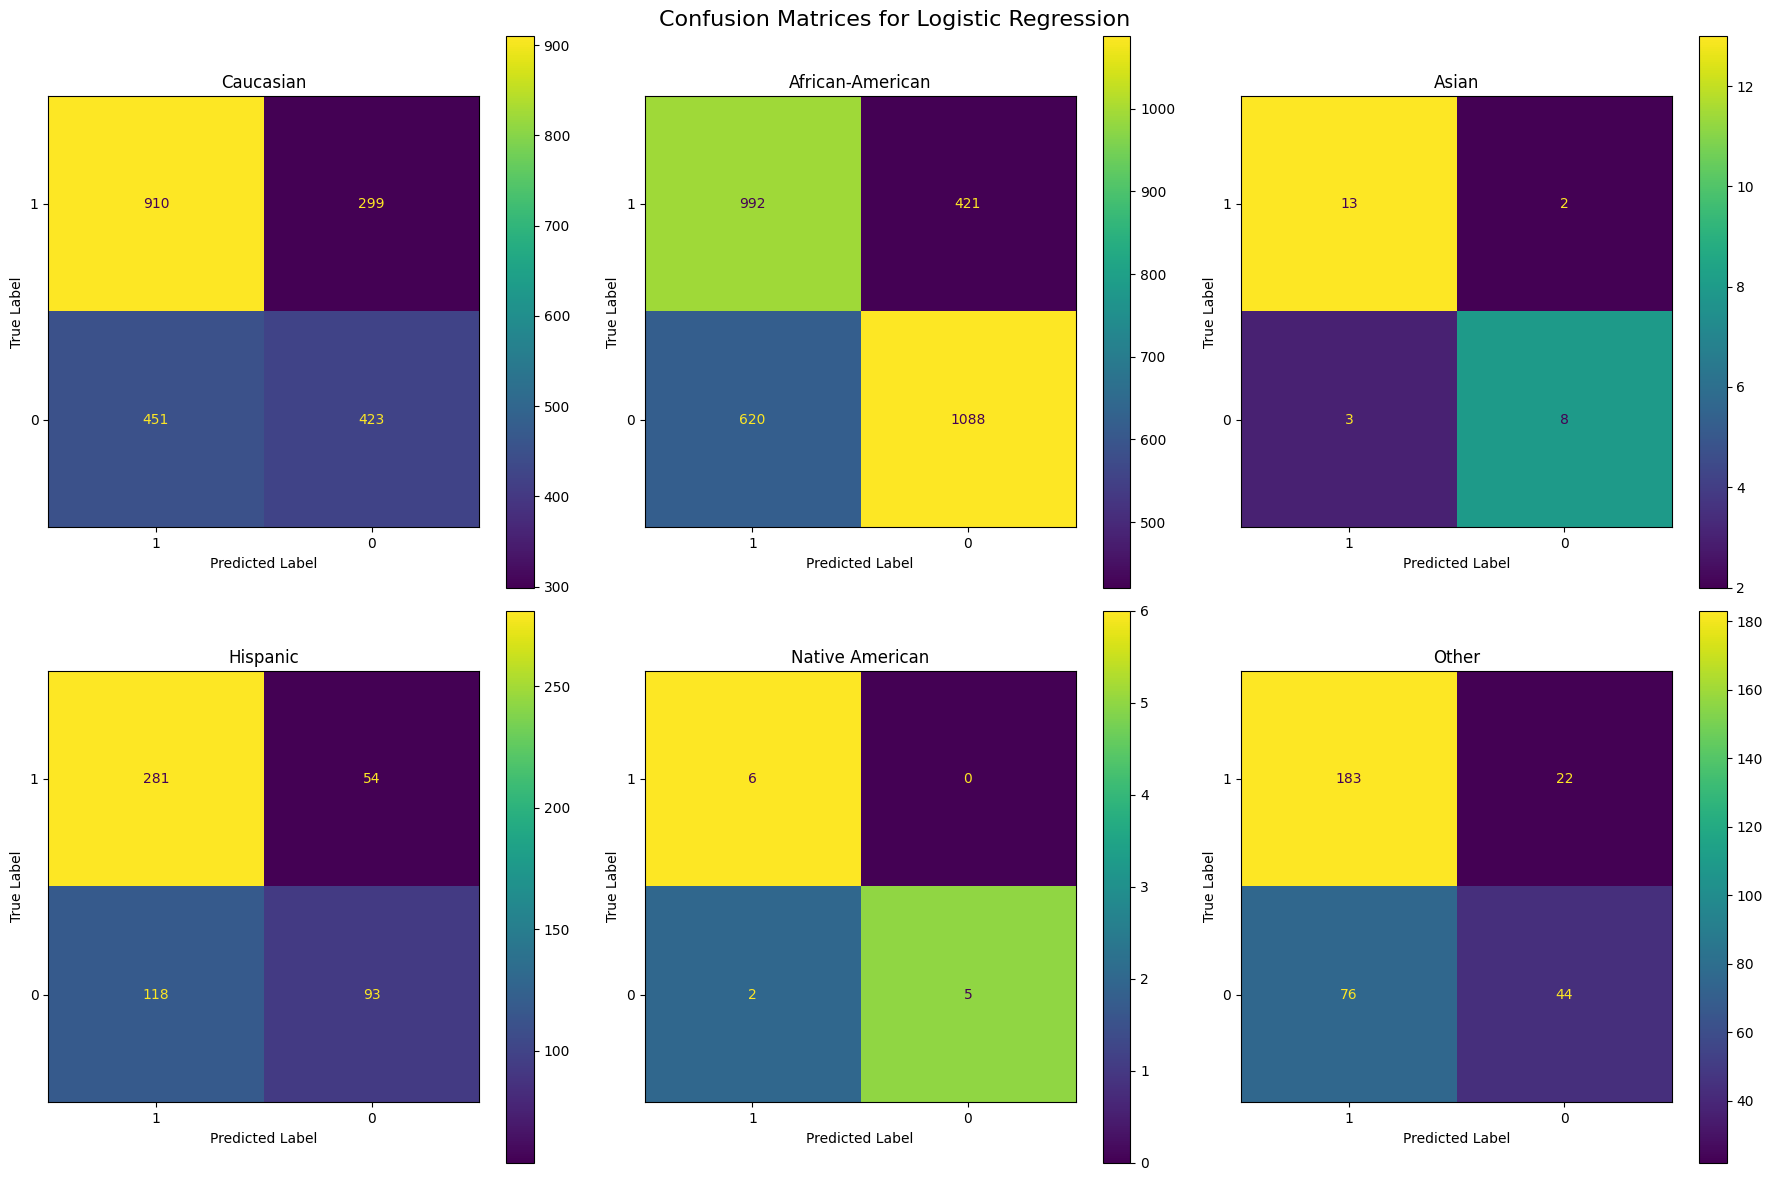

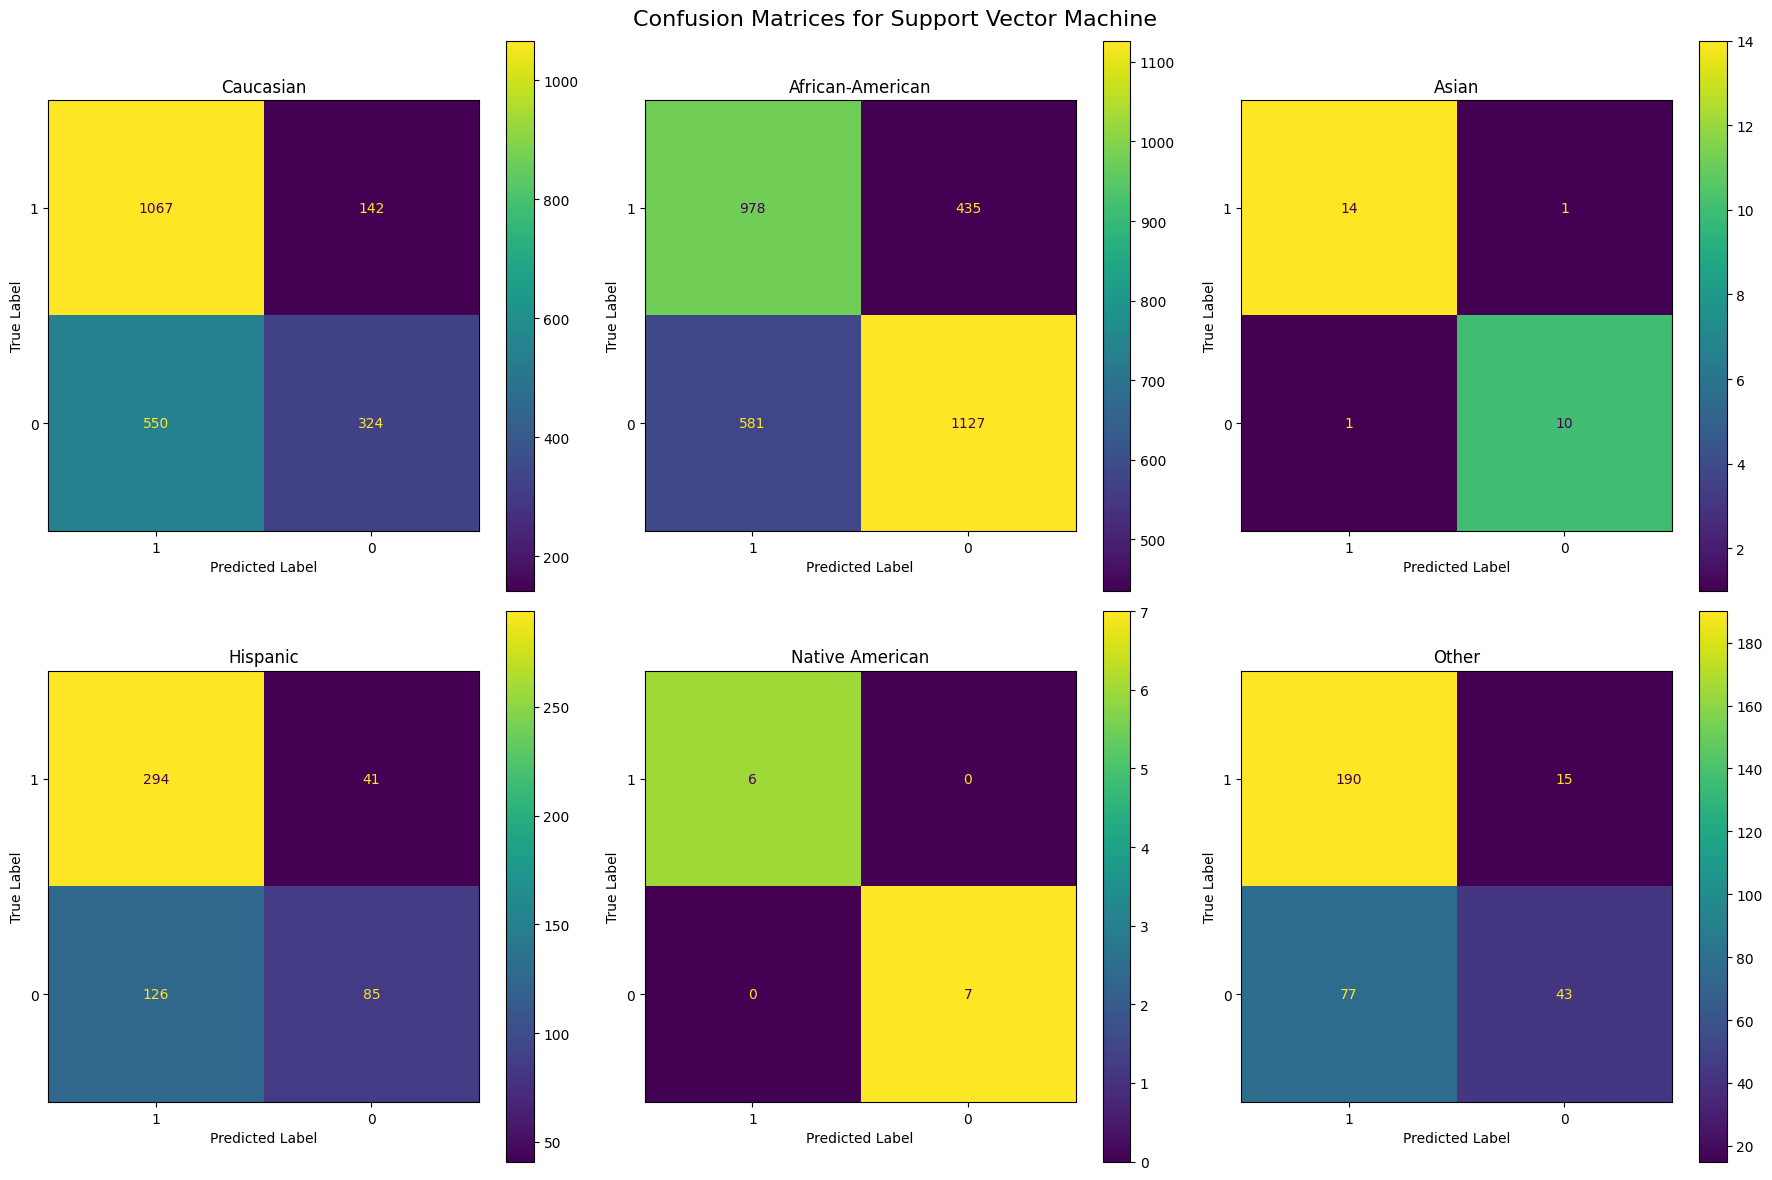


Metrics for Logistic Regression:

Race: Caucasian
confusion_matrix:
[[910 299]
 [451 423]]
accuracy: 0.6399423907825252
precision: 0.5858725761772853
recall: 0.4839816933638444
f1_score: 0.5300751879699248

Race: African-American
confusion_matrix:
[[ 992  421]
 [ 620 1088]]
accuracy: 0.6664530599166933
precision: 0.7210072895957588
recall: 0.6370023419203747
f1_score: 0.6764065899906745

Race: Asian
confusion_matrix:
[[13  2]
 [ 3  8]]
accuracy: 0.8076923076923077
precision: 0.8
recall: 0.7272727272727273
f1_score: 0.761904761904762

Race: Hispanic
confusion_matrix:
[[281  54]
 [118  93]]
accuracy: 0.684981684981685
precision: 0.6326530612244898
recall: 0.44075829383886256
f1_score: 0.5195530726256984

Race: Native American
confusion_matrix:
[[6 0]
 [2 5]]
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.7142857142857143
f1_score: 0.8333333333333333

Race: Other
confusion_matrix:
[[183  22]
 [ 76  44]]
accuracy: 0.6984615384615385
precision: 0.6666666666666666
recall: 0.366666666

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42, probability=True),
}

# Dictionary to hold metrics for each classifier and race
all_race_metrics = {clf_name: {} for clf_name in classifiers.keys()}

# Define races
races = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return cm, accuracy, precision, recall, f1

# Function to calculate fairness metrics
def calculate_fairness_metrics(df, privileged_group, unprivileged_group, target_col, pred_col):
    privileged_df = df[df['race'] == privileged_group]
    unprivileged_df = df[df['race'] == unprivileged_group]
    
    privileged_selection_rate = (privileged_df[pred_col] == 1).mean()
    unprivileged_selection_rate = (unprivileged_df[pred_col] == 1).mean()
    disparate_impact_ratio = unprivileged_selection_rate / privileged_selection_rate
    
    privileged_true_positive_rate = recall_score(privileged_df[target_col], privileged_df[pred_col])
    unprivileged_true_positive_rate = recall_score(unprivileged_df[target_col], unprivileged_df[pred_col])
    equal_opportunity_difference = privileged_true_positive_rate - unprivileged_true_positive_rate
    
    return disparate_impact_ratio, equal_opportunity_difference

# Loop through each classifier
for clf_name, clf in classifiers.items():
    print(f"Training and evaluating {clf_name}...")
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Fit the pipeline
    pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    
    # Get predictions
    df['pred_baseline'] = pipe.predict(X)
    df['pred_baseline_prob'] = pipe.predict_proba(X)[:, 1]
    
    # Calculate metrics for each race
    for race in races:
        race_data = df[df['race'] == race]
        y_true = race_data['is_recid']
        y_pred = race_data['pred_baseline']
        
        cm, accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
        
        if race not in all_race_metrics[clf_name]:
            all_race_metrics[clf_name][race] = {
                'confusion_matrix': cm,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
        else:
            all_race_metrics[clf_name][race] = {
                'confusion_matrix': cm,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
    
    # Calculate fairness metrics
    privileged_group = 'Caucasian'
    unprivileged_group = 'African-American'
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, privileged_group, unprivileged_group, 'is_recid', 'pred_baseline')
    
    all_race_metrics[clf_name]['fairness_metrics'] = {
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference
    }

# Plot confusion matrices for each classifier and race
for clf_name in classifiers.keys():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Confusion Matrices for {clf_name}', fontsize=16)
    
    for ax, race in zip(axes.flatten(), races):
        ConfusionMatrixDisplay(all_race_metrics[clf_name][race]['confusion_matrix'], display_labels=[1, 0]).plot(ax=ax, cmap='viridis')
        ax.set_title(f'{race}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

# Optionally, you can print or further analyze the race metrics for each classifier
for clf_name in classifiers.keys():
    print(f"\nMetrics for {clf_name}:")
    for race in races:
        print(f"\nRace: {race}")
        for metric, value in all_race_metrics[clf_name][race].items():
            if metric == 'confusion_matrix':
                print(f"{metric}:\n{value}")
            else:
                print(f"{metric}: {value}")
    # Print fairness metrics
    print(f"\nFairness Metrics for {clf_name}:")
    for metric, value in all_race_metrics[clf_name]['fairness_metrics'].items():
        print(f"{metric}: {value:.4f}")


Best threshold: 0.11
Fairness Metrics at best threshold:
disparate_impact_ratio: 1.0257
equal_opportunity_difference: -0.0068


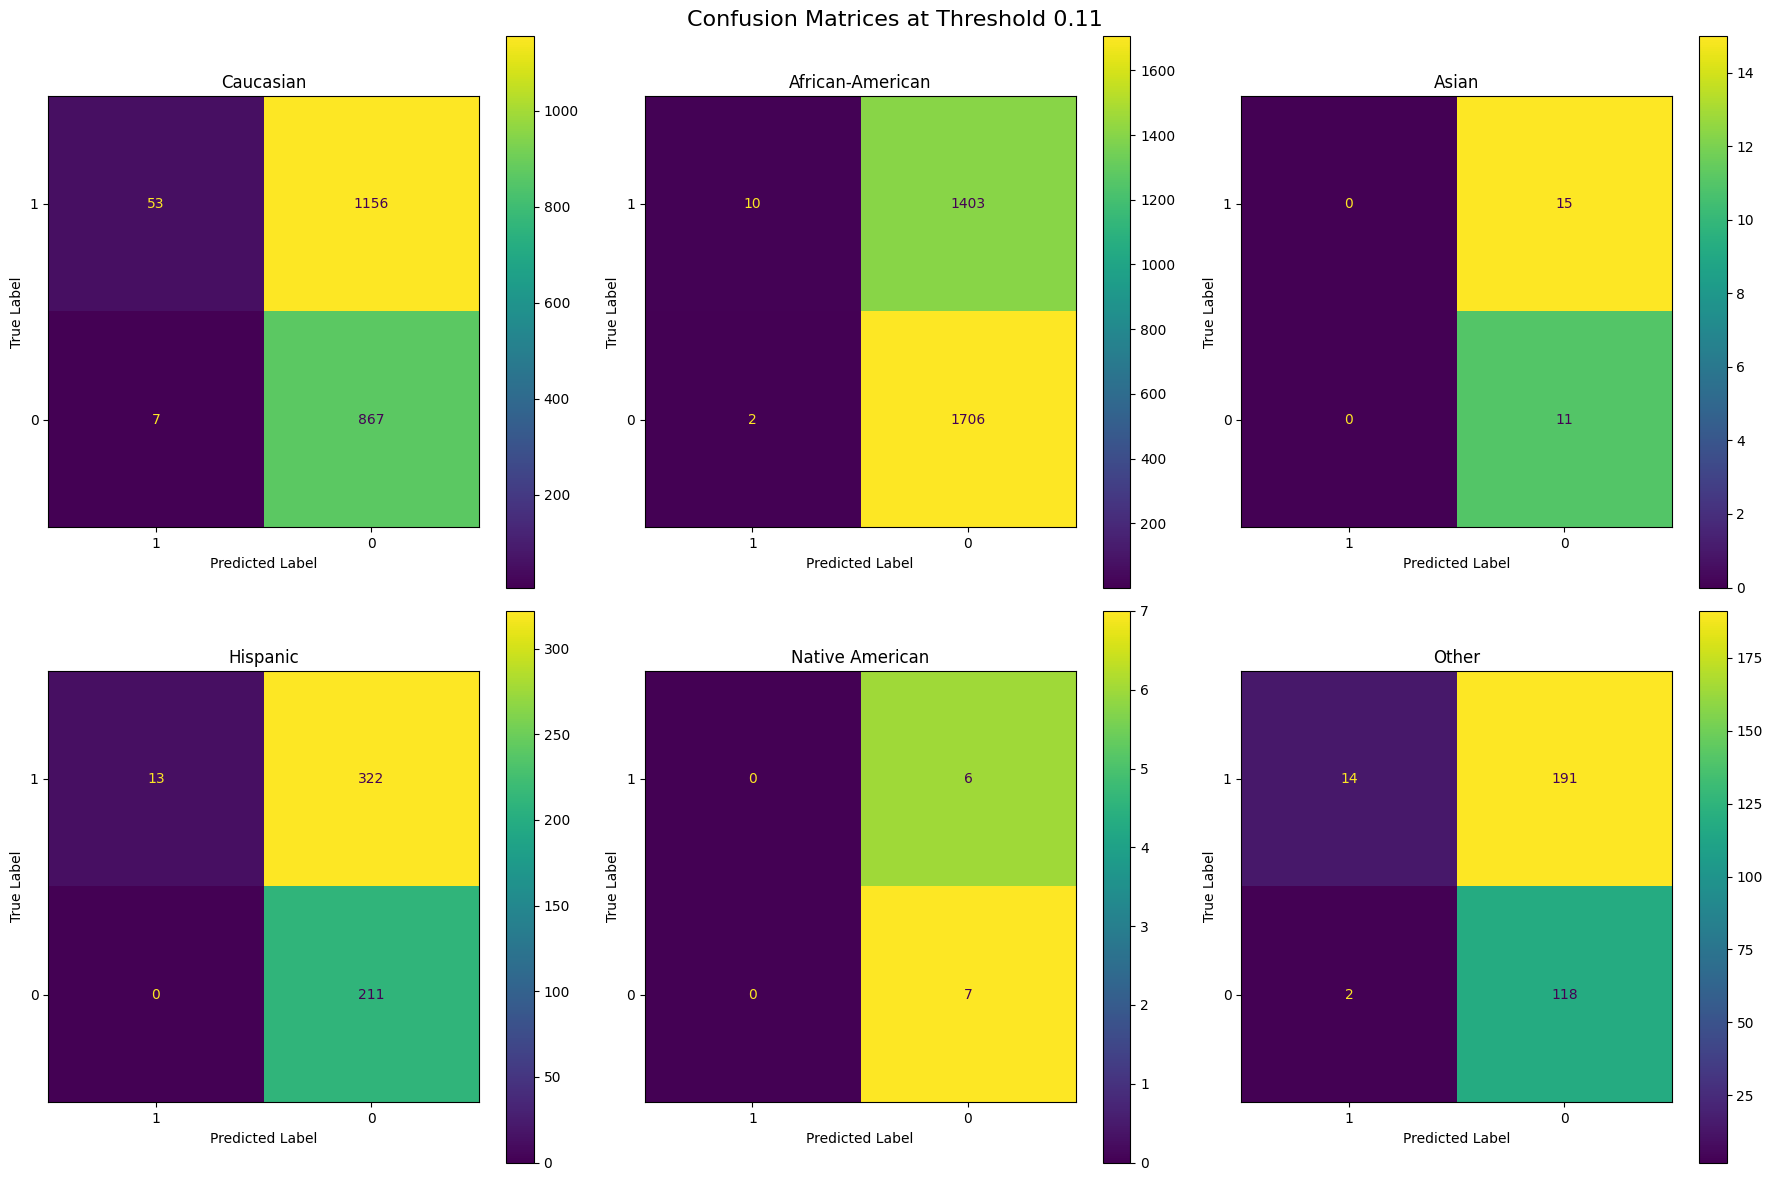


Metrics at Threshold 0.11:

Race: Caucasian
confusion_matrix:
[[  53 1156]
 [   7  867]]
accuracy: 0.44167066730676907
precision: 0.42857142857142855
recall: 0.9919908466819222
f1_score: 0.598550224370038

Race: African-American
confusion_matrix:
[[  10 1403]
 [   2 1706]]
accuracy: 0.5498237744312721
precision: 0.5487294950144741
recall: 0.9988290398126464
f1_score: 0.7083246834129127

Race: Asian
confusion_matrix:
[[ 0 15]
 [ 0 11]]
accuracy: 0.4230769230769231
precision: 0.4230769230769231
recall: 1.0
f1_score: 0.5945945945945945

Race: Hispanic
confusion_matrix:
[[ 13 322]
 [  0 211]]
accuracy: 0.41025641025641024
precision: 0.39587242026266417
recall: 1.0
f1_score: 0.5672043010752688

Race: Native American
confusion_matrix:
[[0 6]
 [0 7]]
accuracy: 0.5384615384615384
precision: 0.5384615384615384
recall: 1.0
f1_score: 0.7000000000000001

Race: Other
confusion_matrix:
[[ 14 191]
 [  2 118]]
accuracy: 0.40615384615384614
precision: 0.3818770226537217
recall: 0.9833333333333333
f1_s

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Placeholder for preprocessor, X_train, y_train, X, df, sample_weights

# Define logistic regression classifier
clf = LogisticRegression(random_state=42, max_iter=1000)

# Define races
races = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return cm, accuracy, precision, recall, f1

# Function to calculate fairness metrics
def calculate_fairness_metrics(df, privileged_group, unprivileged_group, target_col, pred_col):
    privileged_df = df[df['race'] == privileged_group]
    unprivileged_df = df[df['race'] == unprivileged_group]
    
    privileged_selection_rate = (privileged_df[pred_col] == 1).mean()
    unprivileged_selection_rate = (unprivileged_df[pred_col] == 1).mean()
    disparate_impact_ratio = unprivileged_selection_rate / privileged_selection_rate
    
    privileged_true_positive_rate = recall_score(privileged_df[target_col], privileged_df[pred_col], zero_division=0)
    unprivileged_true_positive_rate = recall_score(unprivileged_df[target_col], unprivileged_df[pred_col], zero_division=0)
    equal_opportunity_difference = privileged_true_positive_rate - unprivileged_true_positive_rate
    
    return disparate_impact_ratio, equal_opportunity_difference

# Pipeline for logistic regression
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Fit the pipeline
pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Get prediction probabilities
df['pred_prob'] = pipe.predict_proba(X)[:, 1]

# Vary threshold to find the optimal one
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
min_disparity = float('inf')

# Dictionary to hold metrics for each threshold
all_metrics = {}

for threshold in thresholds:
    df['pred_baseline'] = (df['pred_prob'] >= threshold).astype(int)
    
    # Calculate metrics for each race
    race_metrics = {}
    for race in races:
        race_data = df[df['race'] == race]
        y_true = race_data['is_recid']
        y_pred = race_data['pred_baseline']
        
        cm, accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
        
        race_metrics[race] = {
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    # Calculate fairness metrics
    privileged_group = 'Caucasian'
    unprivileged_group = 'African-American'
    disparate_impact_ratio, equal_opportunity_difference = calculate_fairness_metrics(df, privileged_group, unprivileged_group, 'is_recid', 'pred_baseline')
    
    race_metrics['fairness_metrics'] = {
        'disparate_impact_ratio': disparate_impact_ratio,
        'equal_opportunity_difference': equal_opportunity_difference
    }
    
    all_metrics[threshold] = race_metrics
    
    # Minimize disparity
    disparity = abs(equal_opportunity_difference)
    if disparity < min_disparity:
        min_disparity = disparity
        best_threshold = threshold

# Use the best threshold to get the final metrics
df['pred_baseline'] = (df['pred_prob'] >= best_threshold).astype(int)
final_metrics = all_metrics[best_threshold]

# Print the best threshold and associated fairness metrics
print(f"Best threshold: {best_threshold}")
print(f"Fairness Metrics at best threshold:")
for metric, value in final_metrics['fairness_metrics'].items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrices for each race at the best threshold
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Confusion Matrices at Threshold {best_threshold}', fontsize=16)

for ax, race in zip(axes.flatten(), races):
    ConfusionMatrixDisplay(final_metrics[race]['confusion_matrix'], display_labels=[1, 0]).plot(ax=ax, cmap='viridis')
    ax.set_title(f'{race}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Optionally, you can print or further analyze the race metrics at the best threshold
print(f"\nMetrics at Threshold {best_threshold}:")
for race in races:
    print(f"\nRace: {race}")
    for metric, value in final_metrics[race].items():
        if metric == 'confusion_matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value}")
